In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [17]:
import pickle
import json
with open("../data/affix_dataset.json", "r", encoding="UTF-8") as fin:
    poly_affixoids = json.load(fin)
with open("../data/affix_dists.pkl", "rb") as fin:
    char_dists = pickle.load(fin)

In [11]:
from sklearn.metrics import silhouette_score
import numpy as np

def compute_silhouette_score(char_item, field_name, seed=12345):
    ex_labels = np.array(char_item["ex_labels"])
    # ex_labels = char_item["ex_labels"]
    dist_mat = char_item[field_name]
    nan_mask = ~np.isnan(dist_mat).all(axis=0)
    dist_mat = dist_mat[nan_mask, :][:, nan_mask]
    ex_labels = ex_labels[nan_mask]
        
    real_score = silhouette_score(
                  dist_mat, ex_labels, 
                  metric="precomputed")
  
    rng = np.random.RandomState(seed)
    # rng = random.Random(seed)
    rand_scores = []  
    for _ in range(1000):  
        # rand_labels = np.array(rng.sample(ex_labels.tolist(), len(ex_labels)))
        # rand_labels = rng.sample(ex_labels, len(ex_labels))            
        rand_labels = rng.choice(ex_labels, len(ex_labels), replace=False)        
        rand_score = silhouette_score(
                      dist_mat, rand_labels, 
                      metric="precomputed")
        rand_scores.append(rand_score)
        
    return real_score, rand_scores

In [16]:
char_item = char_dists["人"]

fields = "J_target_dists,J_counter_dists,pred_emb_dists,tenc_emb_dists".split(",")
for field_name in fields:  
    real_score, rand_scores = compute_silhouette_score(char_item, field_name, 12)
    print(f"-- {field_name} --")
    print("Sample score: ", real_score)
    print("Random p(x>Z): ", 1-np.sum(real_score>rand_scores)/len(rand_scores))


-- J_target_dists --
Sample score:  0.03247304537697411
Random p(x>Z):  0.007000000000000006
-- J_counter_dists --
Sample score:  0.04156077390912944
Random p(x>Z):  0.007000000000000006
-- pred_emb_dists --
Sample score:  -0.017208360523811576
Random p(x>Z):  0.573
-- tenc_emb_dists --
Sample score:  -0.007327341361472626
Random p(x>Z):  0.39


In [22]:
from tqdm.auto import tqdm

fields = "J_target_dists,J_counter_dists,pred_emb_dists,tenc_emb_dists".split(",")
var_names = "Jtgt,Jctr,pred,tenc".split(",")
char_stats = {}
for char, char_item in tqdm(char_dists.items()):
    stat_item = {}    
    for field_name, var_name in zip(fields, var_names):  
        try:
            real_score, rand_scores = compute_silhouette_score(char_item, field_name, 12)
            pval = 1-np.sum(real_score>rand_scores)/len(rand_scores)
        except ValueError:
            real_score, rand_scores = np.NaN, []
            pval = np.NaN
        stat_item[f"{var_name}_sample"] = real_score
        stat_item[f"{var_name}_pval"] = pval
        stat_item[f"{var_name}_rand_scores"] = rand_scores
    char_stats[char] = stat_item


  0%|          | 0/796 [00:00<?, ?it/s]

In [27]:
import pandas as pd
char_frame_data = []
for char, stat_item in char_stats.items():
    char_frame_data.append(dict(
        char=char,
        Jtgt_pval=stat_item["Jtgt_pval"],
        Jctr_pval=stat_item["Jctr_pval"],
        pred_pval=stat_item["pred_pval"],
        tenc_pval=stat_item["tenc_pval"]
    ))
char_frame = pd.DataFrame.from_records(char_frame_data).set_index("char")

In [50]:
(char_frame<0.05).sum()/char_frame.shape[0]

Jtgt_pval    0.508794
Jctr_pval    0.483668
pred_pval    0.271357
tenc_pval    0.056533
dtype: float64

In [68]:
char_frame.iloc[char_frame.Jtgt_pval.argmin()]

Jtgt_pval    0.000
Jctr_pval    0.000
pred_pval    0.011
tenc_pval    0.053
Name: 土, dtype: float64

In [69]:
poly_affixoids["土"]

[{'def': 'soil,earth,clay,land',
  'ex': [['土石', 50], ['土改', 28], ['土層', 16], ['土堤', 9], ['土壩', 6]]},
 {'def': 'local,native',
  'ex': [['土雞', 22], ['土狗', 17], ['土狼', 5], ['土豪', 5], ['土番', 2]]},
 {'def': 'soil,earth,clay,land',
  'ex': [['水土', 97], ['廢土', 55], ['黃土', 28], ['失土', 10], ['棄土', 8]]}]

In [33]:
char_frame.median()

Jtgt_pval    0.0460
Jctr_pval    0.0550
pred_pval    0.1545
tenc_pval    0.3220
dtype: float64

In [46]:
char_long = pd.melt(char_frame, var_name="variable", value_name="pval")

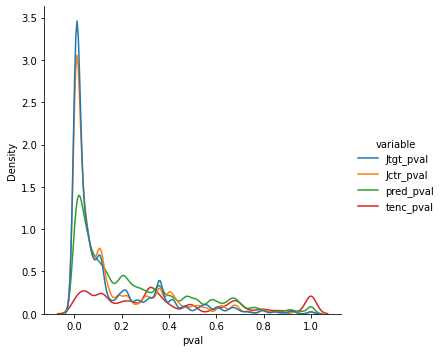

In [49]:
import seaborn as sns
sns.displot(char_long, x="pval", hue="variable", kind="kde", bw_adjust=.25)

In [52]:
char_frame.query("Jtgt_pval<0.01")

,Jtgt_pval,Jctr_pval,pred_pval,tenc_pval
char,,,,
人,0.007,0.007,0.573,0.390
刀,0.007,0.049,0.035,0.111
下,0.001,0.013,0.027,0.109
土,0.000,0.000,0.011,0.053
大,0.007,0.007,0.007,0.046
...,...,...,...,...
為,0.000,0.000,0.000,NaN
等,0.009,0.017,0.098,0.359
叫,0.002,0.011,0.131,0.168


In [65]:
import math
math.factorial(15)/(math.factorial(5)**3)

756756.0

In [56]:
char_frame.query("Jtgt_pval>0.5")

,Jtgt_pval,Jctr_pval,pred_pval,tenc_pval
char,,,,
上,0.645,0.851,0.000,0.042
介,0.526,0.507,0.626,0.690
天,0.549,0.544,0.949,0.934
引,0.669,0.669,0.669,0.359
世,0.630,0.524,0.313,NaN
包,0.794,0.526,0.322,NaN
卡,0.680,0.680,0.862,NaN
母,0.529,0.002,0.364,0.362
年,0.923,0.934,0.376,0.351
